# Jacob Daffer, Lucy Shimela, Aayush Khatiwada
## Assignment 2 : Linear Regression

# Imports

In [ ]:
from itertools import combinations_with_replacement

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

%matplotlib inline

## Standardization Functions

In [ ]:
# input X is a pandas Series.
# output is a standardized version of the panda Series
# https://en.wikipedia.org/wiki/Feature_scaling#Mean_normalization
def mean_standardize(X: pd.Series):
  return pd.Series(
      [(X[i] - X.mean()) / (X.max() - X.min()) for i in range(X.count())])

# 1. polynomial_features(X, degree)

**Arguments**:
  - **X** : A numpy array with rows representing data samples and columns representing features (d-dimensional feature).
  - **degree** : an integer representing the degree of the polynomial features. 
   - Default = 1.

**Returns** :
  - A new feature matrix consisting of all polynomial combinations of the features with degree equal to the specified degree. 
  
For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [a, b, $a^2$, ab, $b^2$].

In [ ]:
def polynomial_features(X, degree=1):
  # So this doesn't cover sparse matricies nor does it really take into account
  # for higher dimensional tensors.
  #
  # This will take in each row and expand it polynomially based on the 
  # combinations with replacement to the degree requested.
  # 
  # Example being if I had degree 2 and I had the values [a,b]
  # it would be expanded to [a, b, aa, ab, bb]\
  #
  # Example being if I had degree 1 and I had the values [a,b],
  # it would be expanded to [a, b, a, b]
  #
  # If the degree is 1 it will copy the data. 
  X = np.asarray(X)
  ret = []
  if X.ndim == 2:
    n_samples, n_features = X.shape
    for i in range(n_samples):
      comb = combinations_with_replacement(X[i], degree)
      row = []
      for j in comb:
        row.append(np.product(j))
      ret.append(np.concatenate((X[i],row)))
  elif X.ndim == 1:
    comb = combinations_with_replacement(X, degree)
    row = []
    for i in comb:
      row.append(np.product(i))
    ret = np.concatenate((X,row))
  else:
    raise(Exception("The tensor diemensions are either higher than 2" + 
                    "or lower than 1"))
  ret = np.asarray(ret)
  return ret




# 2. mean_square_error (true_labels, prediction_labels)
**Arguments** :
- **true_labels** : a 1D numpy array containing data with float values of the true labels.
- **prediction_labels** : a 1D numpy array containing data with float values predicted labels by your model.

**Returns**:

- **cost**: a float value containing mean squared error between Y_true and Y_pred.


In [ ]:
def mean_squared_error(true_labels, prediction_labels):
  error = np.subtract(true_labels, prediction_labels)
  return np.mean(np.square(error))

def root_mean_squared_error(true_labels, prediction_labels):
  return np.sqrt(mean_squared_error(true_labels, prediction_labels))

# 3. Learning Curves


---


Implement the following function to compute training and validation errors. It will be used to plot learning curves. 

1. The function takes the feature matrix $X$ (usually the training data matrix).

 a. The training size (from the *train_size* parameter).

By using cross-validation computes the average *mean_squared_error* for the training fold and the validation fold. 

It iterates through the entire feature matix $X$ with an increment step of the *train_size*. 

<br/>

For example, if there are 50 samples(rows)in the feature matrix $X$ and the *train_size* is 10.

- The function will start from the first 10 samples and will successively add 10 samples in each iteration: 
 - 10, 20, 30 , 40, and finally 50 samples

- During each iteration it will use **k-fold** cross-validation to compute the average _**root_mean_squared_error**_ for the training fold and the validation fold.

- For training the model (using the _**fit**_ method) it will use the model parameters from the function argument. 

- The function will return two arrays containing training and validation root-mean-square error values.

## learning_curve(model, X, Y, cv, train_size=1, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs)

**Arguments** :

- **model** : a class that implements the *fit* and *predict* methods.

- **X** : A numpy array with rows representing data samples and columns representing features.

- **Y** : 1D numpy array with labels corresponding to each row of the feature matrix $X$.

- **cv** : An integer that specifies the number of folds in a **k-fold** cross-validation.

- **train_sizes** : An integer or float that is the Relative or absolute numbers of training examples used to generate the learning curve.
 - If the data type is a float, it is regarded as a fraction of the maximum size of the training set and has to be within (0, 1].
 - Otherwise it is interpreted as absolute sizes of the training sets.

- **learning_rate** : A float that provides the step size for parameter update.

- **epochs** : An Integer for the maximum number of passes over the training data for updating the weight vector.

- **tol** : *Optional* A float for stopping criterion.
  - If it is not None, the iterations will stop when the error is greater than previous error.
  - If it is None, the number of iterations will be set by the “epochs”.

- **regularizer** : A string value that could be one of the following:
 - If it’s set to None, the cost function without the regularization term will be used for computing the gradient and updating the weight vector. 
 - "*l1*" or "*l2*", the appropriate regularized cost function needs to be used for computing the gradient and updating the weight vector.

- **lambd** : A float for the regularization coefficient.
  - It is used only when the “regularizer” is set to "*l1*" or "*l2*".

**Returns** :

- **train_scores** : A numpy array of the root-mean-square error values on the training sets.

- **val_scores** : A numpy array of the root-mean-square error values on validation sets.

In [ ]:
#
# Use the kFold function(known as sFold function from previous assignment)
#

def kFold(data, 
          labels, 
          model, 
          model_args, 
          error_function, 
          folds=5):
  
    data_size = data.shape[0] 
    s_partition_size = 1 / folds
    segment_indexes = [ [int(np.floor(s_partition_size * i * data_size)), 
                         int(np.floor(s_partition_size * (i + 1) * data_size) - 1)] 
                       for i in range(folds) ]
    # [
    #  [2, 3]]
    ret = {}
    for p in range(folds):
        key = str('k%d' % p)
        # takes the current segment as training data
        test_data = data[segment_indexes[p][0]:segment_indexes[p][1]]
        test_labels = labels[segment_indexes[p][0]:segment_indexes[p][1]]
        
        # creates copies of the data and labels with the testing data segment 
        # removed.
        train_data =\
         np.delete(data, 
                   np.s_[segment_indexes[p][0]:segment_indexes[p][1]], 0)
        train_labels =\
         np.delete(labels, 
                   np.s_[segment_indexes[p][0]:segment_indexes[p][1]], 0)
        
        model.fit(train_data, train_labels, **model_args)
        predcition_training = model.predict(X=train_data)
        validation_training = model.predict(X=test_data)
        
        # error_function is a decorator for the functioon being used 
        # so long as you pass a function without the parenthesis     
        train_score = error_function(train_labels, predcition_training)   
        validation_score = error_function(test_labels, validation_training)
        ret[key] = {'train_score' : train_score, 
                    'validation_score' : validation_score}
        
        
    return ret

In [ ]:
def learning_curve(model, 
                   X, 
                   Y, 
                   cv, 
                   train_size=1, 
                   learning_rate=0.01, 
                   epochs=1000, 
                   tol=None, 
                   regularizer=None, 
                   lambd=0.0, 
                   **kwargs):
  
  #Get training set size
  if np.issubdtype(train_size.dtype, np.floating):
    if np.min(train_size >= 0) and np.max(train_size <= 1):
      train_size = np.unique(train_size*X.shape[0])
      train_size = np.ceil(train_size)
      train_size = np.int32(train_size)

  training_scores = []
  validation_scores = []
  
  results = []
  for train_set in train_size:
    data = X[0:train_set]
    labels = np.asarray([Y[0:train_set]]).T
    kfolds = kFold(data=data, 
                   labels=labels,
                   model=model,
                   model_args={
                       'learning_rate': learning_rate, 
                       'epochs': epochs,
                       'tol': tol,
                       'regularizer': regularizer,
                       'lambd': lambd
                       },
                   error_function=kwargs['error_function'],
                   folds=cv)
    results.append(kfolds)
  for res in results:
    avg_training_score_sum = 0
    avg_validation_score_sum = 0
    for fold in res:
        avg_training_score_sum += res[fold]['train_score']
        avg_validation_score_sum += res[fold]['validation_score']
    training_scores.append(avg_training_score_sum / len(res))
    validation_scores.append(avg_validation_score_sum / len(res))

  return results, training_scores, validation_scores, train_size

# 4. Plot Polynomial Complexity

Implement the following function to plot the training and validation *root_mean_square_error* of the data matrix $X$ for various polynomial degrees starting from 1 up to the value set by _**maxPolynomialDegree**_. 

It takes the data matrix $X$ and the _**maxPolynomialDegree**_
- For each polynomial degree it will augment the data matrix
- Use **k-fold** cross-validation to compute the average *mean_square_error* for both the training and the validation fold.
- For training the model use the **fit** method. 
- Finally, the function will plot the *root-mean-square error* values for the training and validation folds
  - for each degree of the data matrix starting from 1 up to the _**maxPolynomialDegree**_.

## plot_polynomial_model_complexity(model, X, Y, cv, maxPolynomialDegree, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs)

**Arguments** :

- **model** : a class that implements the *fit* and *predict* methods.

- **X** : A numpy array with rows representing data samples and columns representing features.

- **Y** : 1D numpy array with labels corresponding to each row of the feature matrix $X$.

- **cv** : An integer that specifies the number of folds in a (Stratified) **k-fold** cross-validation.

- **maxPolynomialDegree** : A integer sed to determine the maximum polynomial degree for $X$.
  - For example, if it is set to 3, thenthe function will compute both the training and validation _**root mean square error**_ values for degree 1, 2 and 3.

- **learning_rate** : A float that provides the step size for parameter update.

- **epochs** : An Integer for the maximum number of passes over the training data for updating the weight vector.

- **tol** : *Optional* A float for stopping criterion.
  - If it is not None, the iterations will stop when the error is greater than previous error.
  - If it is None, the number of iterations will be set by the “epochs”.

- **regularizer** : A string value that could be one of the following:
 - If it’s set to None, the cost function without the regularization term will be used for computing the gradient and updating the weight vector. 
 - "*l1*" or "*l2*", the appropriate regularized cost function needs to be used for computing the gradient and updating the weight vector.

- **lambd** : A float for the regularization coefficient.
  - It is used only when the “regularizer” is set to "*l1*" or "*l2*".

**Returns** :
- There is no return value. <br/> 
This function plots the root-mean-square error values for both the training set and the validation set for degree of X between 1 and _**maxPolynomialDegree**_.

In [ ]:

def stratified_error(folds):
  return {"k{}".format(i) : {'train_score' : 1, 'validation_score': 1} for i in range(folds)}


In [ ]:

#
# Use the kFold function(known as sFold function from previous assignment)
#

def stratified_kFold(data, 
                     labels, 
                     model, 
                     model_args, 
                     error_function, 
                     folds=5):

  #print("Start of Stratified K-Fold")

  # Get the location of each label
  unique, inverse = np.unique(labels, return_inverse=True)
  
  # making pools of indeicies each representing a target label
  # Ex: label 0 has index 1,3,5,10 and label 1 has index 0,2,4 
  #     and label 2 has index 6,7,8,9
  label_pools = []
  for u in range(len(unique)):
    index_list = []
    for i in range(len(inverse)):
      if (u == inverse[i]):
        index_list.append(i)
    label_pools.append(index_list)
  
  #print("Label Pools :")
  #[print(i) for i in label_pools]

  # using the number of folds to produce partion sized index pools with straified values
  index_pools = [ [] for i in range(folds)]
  i = 0
  for label_pool in label_pools:
    if (len(label_pool) < folds):
      print("The label ' {} ' did not have the sufficient "+
            "length to fit the fold count of {} : {}"\
            .format(unique[i], folds, label_pool))
      return stratified_error(folds)
    split_pool = np.array_split(label_pool, folds)
    for fold in range(folds):
      index_pools[fold].append(split_pool[fold])
  
  for fold in range(folds):
    index_pool = np.concatenate(index_pools[fold])
    index_pools[fold] = index_pool.reshape(-1)
  
  # not sure if necessary but flatening index pools 
  # if they are not already
  for index_pool in index_pools:
    index_pool = np.asarray(index_pool)
    index_pool = index_pool.ravel()

  #print("Index Pools : ")
  #[print(i.tolist()) for i in index_pools]
  
  # So these index pools are the size of the fold so 
  # we can just dump the index pool and numpy will extract 
  # the data and label at those indicies
  ret = {}
  for p in range(folds):
    #print("\n\n At fold [{}]".format(p))
    #print(len(index_pools))
    key = str('k%d' % p)
    test_data = data[index_pools[p]]
    test_labels = labels[index_pools[p]]
    
    #print("test_data : \n{}".format(test_data))
    #print("test_labels : \n{}".format(np.ravel(test_labels).tolist()))

    train_pools = index_pools.copy()
    train_pools.pop(p)
    train_pools = np.array(train_pools)
    train_pools = np.concatenate(([i for i in train_pools]))

    train_data = data[train_pools]
    train_labels = labels[train_pools]

    #print("train_data : \n{}".format(train_data))
    #print("train_labels : \n{}".format(train_labels))

    model.fit(train_data, train_labels, **model_args)
    predcition_training = model.predict(X=train_data)
    validation_training = model.predict(X=test_data)
    
    # error_function is a decorator for the functioon being used 
    # so long as you pass a function without the parenthesis     
    train_score = error_function(train_labels, predcition_training)   
    validation_score = error_function(test_labels, validation_training)
    ret[key] = {'train_score' : train_score, 
                'validation_score' : validation_score} 
  #print("End of Stratified K-Fold")    
  return ret

In [ ]:
def plot_polynomial_model_complexity(model, 
                                     X, 
                                     Y, 
                                     cv, 
                                     maxPolynomialDegree, 
                                     error_function,
                                     learning_rate=0.01, 
                                     epochs=1000, 
                                     tol=None, 
                                     regularizer=None, 
                                     lambd=0.0,
                                     **kwargs):
  
  degree_list = [i+1 for i in range(maxPolynomialDegree)]
  results = []

  for degree in degree_list:
    data = polynomial_features(X, degree)
    labels = np.asarray([Y]).T
    kfolds = stratified_kFold(data,
                  labels, 
                  model, 
                  model_args={
                      'learning_rate': learning_rate, 
                      'epochs': epochs,
                      'tol': tol,
                      'regularizer': regularizer,
                      'lambd': lambd
                  }, 
                  error_function=error_function, 
                  folds=cv)
    results.append(kfolds)

  training_scores = []
  validation_scores = []

  for res in results:
    avg_training_score_sum = 0
    avg_validation_score_sum = 0
    skip = 0
    for fold in res:
        if ((res[fold]['train_score'] != 1) and 
            (res[fold]['validation_score'] != 1)):
          avg_training_score_sum += res[fold]['train_score']
          avg_validation_score_sum += res[fold]['validation_score']
        else:
          skip += 1
    training_scores.append(avg_training_score_sum / (len(res) - skip))
    validation_scores.append(avg_validation_score_sum / (len(res) - skip))
  
  #print(json.dumps(results, indent=2))
  fig = plt.figure(figsize=(20,10))
  plt.plot(degree_list, training_scores, 'bo-')
  plt.plot(degree_list, validation_scores, 'ro-')
  plt.title('RSME for Varying Degree')
  plt.xlabel('Degree')
  plt.ylabel('RSME')


# 5. Linear_Regression Class
## a.) fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, lambd=0.0, **kwargs)

The _**fit**_ method should implement the **batch gradient descent** algorithm.

The _**fit**_ method should use a weight vector $\hat{\theta}$ that contains the parameters for the model. One parameter for each feature and one for bias.

$\hat{\theta}$ should be a 1D column vector.

Finally, it should update the model parameter $\theta$ to be used in _**predict**_ method as follows.

```
    self.theata = theta_hat
```

**Arguments**:

- **X** : A numpy array with rows representing data samples and columns representing features.

- **Y** : 1D numpy array with labels corresponding to each row of the feature matrix $X$.

- **learning_rate** : A float that provides the step size for parameter update.

- **epochs** : An Integer for the maximum number of passes over the training data for updating the weight vector.

- **tol** : *Optional* A float for stopping criterion.
  - If it is not None, the iterations will stop when the error is greater than previous error.
  - If it is None, the number of iterations will be set by the “epochs”.

- **regularizer** : A string value that could be one of the following:
 - If it’s set to None, the cost function without the regularization term will be used for computing the gradient and updating the weight vector. 
 - "*l1*" or "*l2*", the appropriate regularized cost function needs to be used for computing the gradient and updating the weight vector.

- **lambd** : A float for the regularization coefficient.
  - It is used only when the “regularizer” is set to "*l1*" or "*l2*".

## b.) predict(self, X):

Method uses **self.theta** to make predictions.

**Arguments** :

- **X** : A numpy matix containing samples to be used for prediction. Its rows represent data samples and columns represent features.

**Returns**:
- 1-D numpy array of predictions for each row in matrix $X$.

In [ ]:
def batch_gradient_descent(learning_rate, 
                           X, 
                           Y, 
                           epochs, 
                           tol, 
                           regularizer, 
                           lambd):
  # X : n x d + 1
  # X.T : d + 1 x n
  # theta : d + 1 x 1
  # y : n x 1
  # n is the number of samples

  alpha = learning_rate
  n = X.shape[0]
  theta = np.zeros(shape=(X.shape[1], 1))

  for i in range(epochs):
    # hyp = X.dot(theta)
    # loss = np.subtract(hyp, Y)
    # gradient = X.T.dot(loss) / n
    gradient = X.T.dot(np.subtract(X.dot(theta), Y)) / n

    if (regularizer == 'l2'):
      regularization = (alpha * lambd * theta) / n
      theta = theta - alpha * gradient - regularization

    elif (regularizer == 'l1'):
      regularization = ((alpha * lambd) / n) * np.sign(theta)
      theta = theta - alpha * gradient - regularization

    else:
      theta = theta - alpha * gradient

    if (tol is not None):
      # epsilon check
      epsilon = np.linalg.norm(theta)
      if ( epsilon < tol) :
        return theta


    #print('epoch[{}] : \n{}'.format(i, theta))
  return theta

In [ ]:
class Linear_Regression:
    
    def __init__(self, algorithm):
        self.algorithm = algorithm
        pass


    def fit(self, X, Y, 
            learning_rate=0.01, epochs=1000, 
            tol=None, regularizer=None, lambd=0.0, **kwargs):
      self.X = X
      self.Y = Y
      self.learning_rate = learning_rate
      self.epochs = epochs
      self.tol = tol
      self.regularizer = regularizer
      self.lambd = lambd
      self.theta = self.algorithm(learning_rate, X, Y, 
                                  epochs, tol, regularizer, lambd)
      pass
    
    def predict(self, X):
      return X.dot(self.theta)


# 6. Read in the winequality-red.csv file

In [ ]:
import urllib
downloader = urllib.request.URLopener()
downloader.retrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", "winequality-red.csv")
downloader.close()
df = pd.read_csv('winequality-red.csv', delimiter=';')
cols = df.columns.to_list()
cols = {i:i.replace(' ','_') for i in cols}
df.rename(columns=cols, inplace=True)

# 7. Use the techniques from the recitation to summarize each of the variables in the dataset in terms of mean, standard deviation, and quartiles. Include this in your report. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
df.describe().to_latex(columns=['fixed_acidity', 
                                'volatile_acidity', 'citric_acid'])

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  fixed\\_acidity &  volatile\\_acidity &  citric\\_acid \\\\\n\\midrule\ncount &    1599.000000 &       1599.000000 &  1599.000000 \\\\\nmean  &       8.319637 &          0.527821 &     0.270976 \\\\\nstd   &       1.741096 &          0.179060 &     0.194801 \\\\\nmin   &       4.600000 &          0.120000 &     0.000000 \\\\\n25\\%   &       7.100000 &          0.390000 &     0.090000 \\\\\n50\\%   &       7.900000 &          0.520000 &     0.260000 \\\\\n75\\%   &       9.200000 &          0.640000 &     0.420000 \\\\\nmax   &      15.900000 &          1.580000 &     1.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
df.describe().to_latex(columns=['residual_sugar', 
                                'chlorides', 'free_sulfur_dioxide'])

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  residual\\_sugar &    chlorides &  free\\_sulfur\\_dioxide \\\\\n\\midrule\ncount &     1599.000000 &  1599.000000 &          1599.000000 \\\\\nmean  &        2.538806 &     0.087467 &            15.874922 \\\\\nstd   &        1.409928 &     0.047065 &            10.460157 \\\\\nmin   &        0.900000 &     0.012000 &             1.000000 \\\\\n25\\%   &        1.900000 &     0.070000 &             7.000000 \\\\\n50\\%   &        2.200000 &     0.079000 &            14.000000 \\\\\n75\\%   &        2.600000 &     0.090000 &            21.000000 \\\\\nmax   &       15.500000 &     0.611000 &            72.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
df.describe().to_latex(columns=['total_sulfur_dioxide', 'density', 'pH'])

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  total\\_sulfur\\_dioxide &      density &           pH \\\\\n\\midrule\ncount &           1599.000000 &  1599.000000 &  1599.000000 \\\\\nmean  &             46.467792 &     0.996747 &     3.311113 \\\\\nstd   &             32.895324 &     0.001887 &     0.154386 \\\\\nmin   &              6.000000 &     0.990070 &     2.740000 \\\\\n25\\%   &             22.000000 &     0.995600 &     3.210000 \\\\\n50\\%   &             38.000000 &     0.996750 &     3.310000 \\\\\n75\\%   &             62.000000 &     0.997835 &     3.400000 \\\\\nmax   &            289.000000 &     1.003690 &     4.010000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
df.describe().to_latex(columns=['sulphates', 'alcohol', 'quality'])

'\\begin{tabular}{lrrr}\n\\toprule\n{} &    sulphates &      alcohol &      quality \\\\\n\\midrule\ncount &  1599.000000 &  1599.000000 &  1599.000000 \\\\\nmean  &     0.658149 &    10.422983 &     5.636023 \\\\\nstd   &     0.169507 &     1.065668 &     0.807569 \\\\\nmin   &     0.330000 &     8.400000 &     3.000000 \\\\\n25\\%   &     0.550000 &     9.500000 &     5.000000 \\\\\n50\\%   &     0.620000 &    10.200000 &     6.000000 \\\\\n75\\%   &     0.730000 &    11.100000 &     6.000000 \\\\\nmax   &     2.000000 &    14.900000 &     8.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

# 8. Shuffle the rows of your data. You can use def = df.sample(frac=1) as an idiomatic way to shuffle the data in Pandas without losing column names.

In [ ]:
random_df = df.sample(frac=1)
feature_df = random_df.drop(columns=['quality'])
target_df = random_df['quality']

In [ ]:
for i in feature_df.columns:
  feature_df[i] = mean_standardize(feature_df[i])

# 9. Generate pair plots using the seaborn package. This will be used to identify and report the redundant features, if there is any.

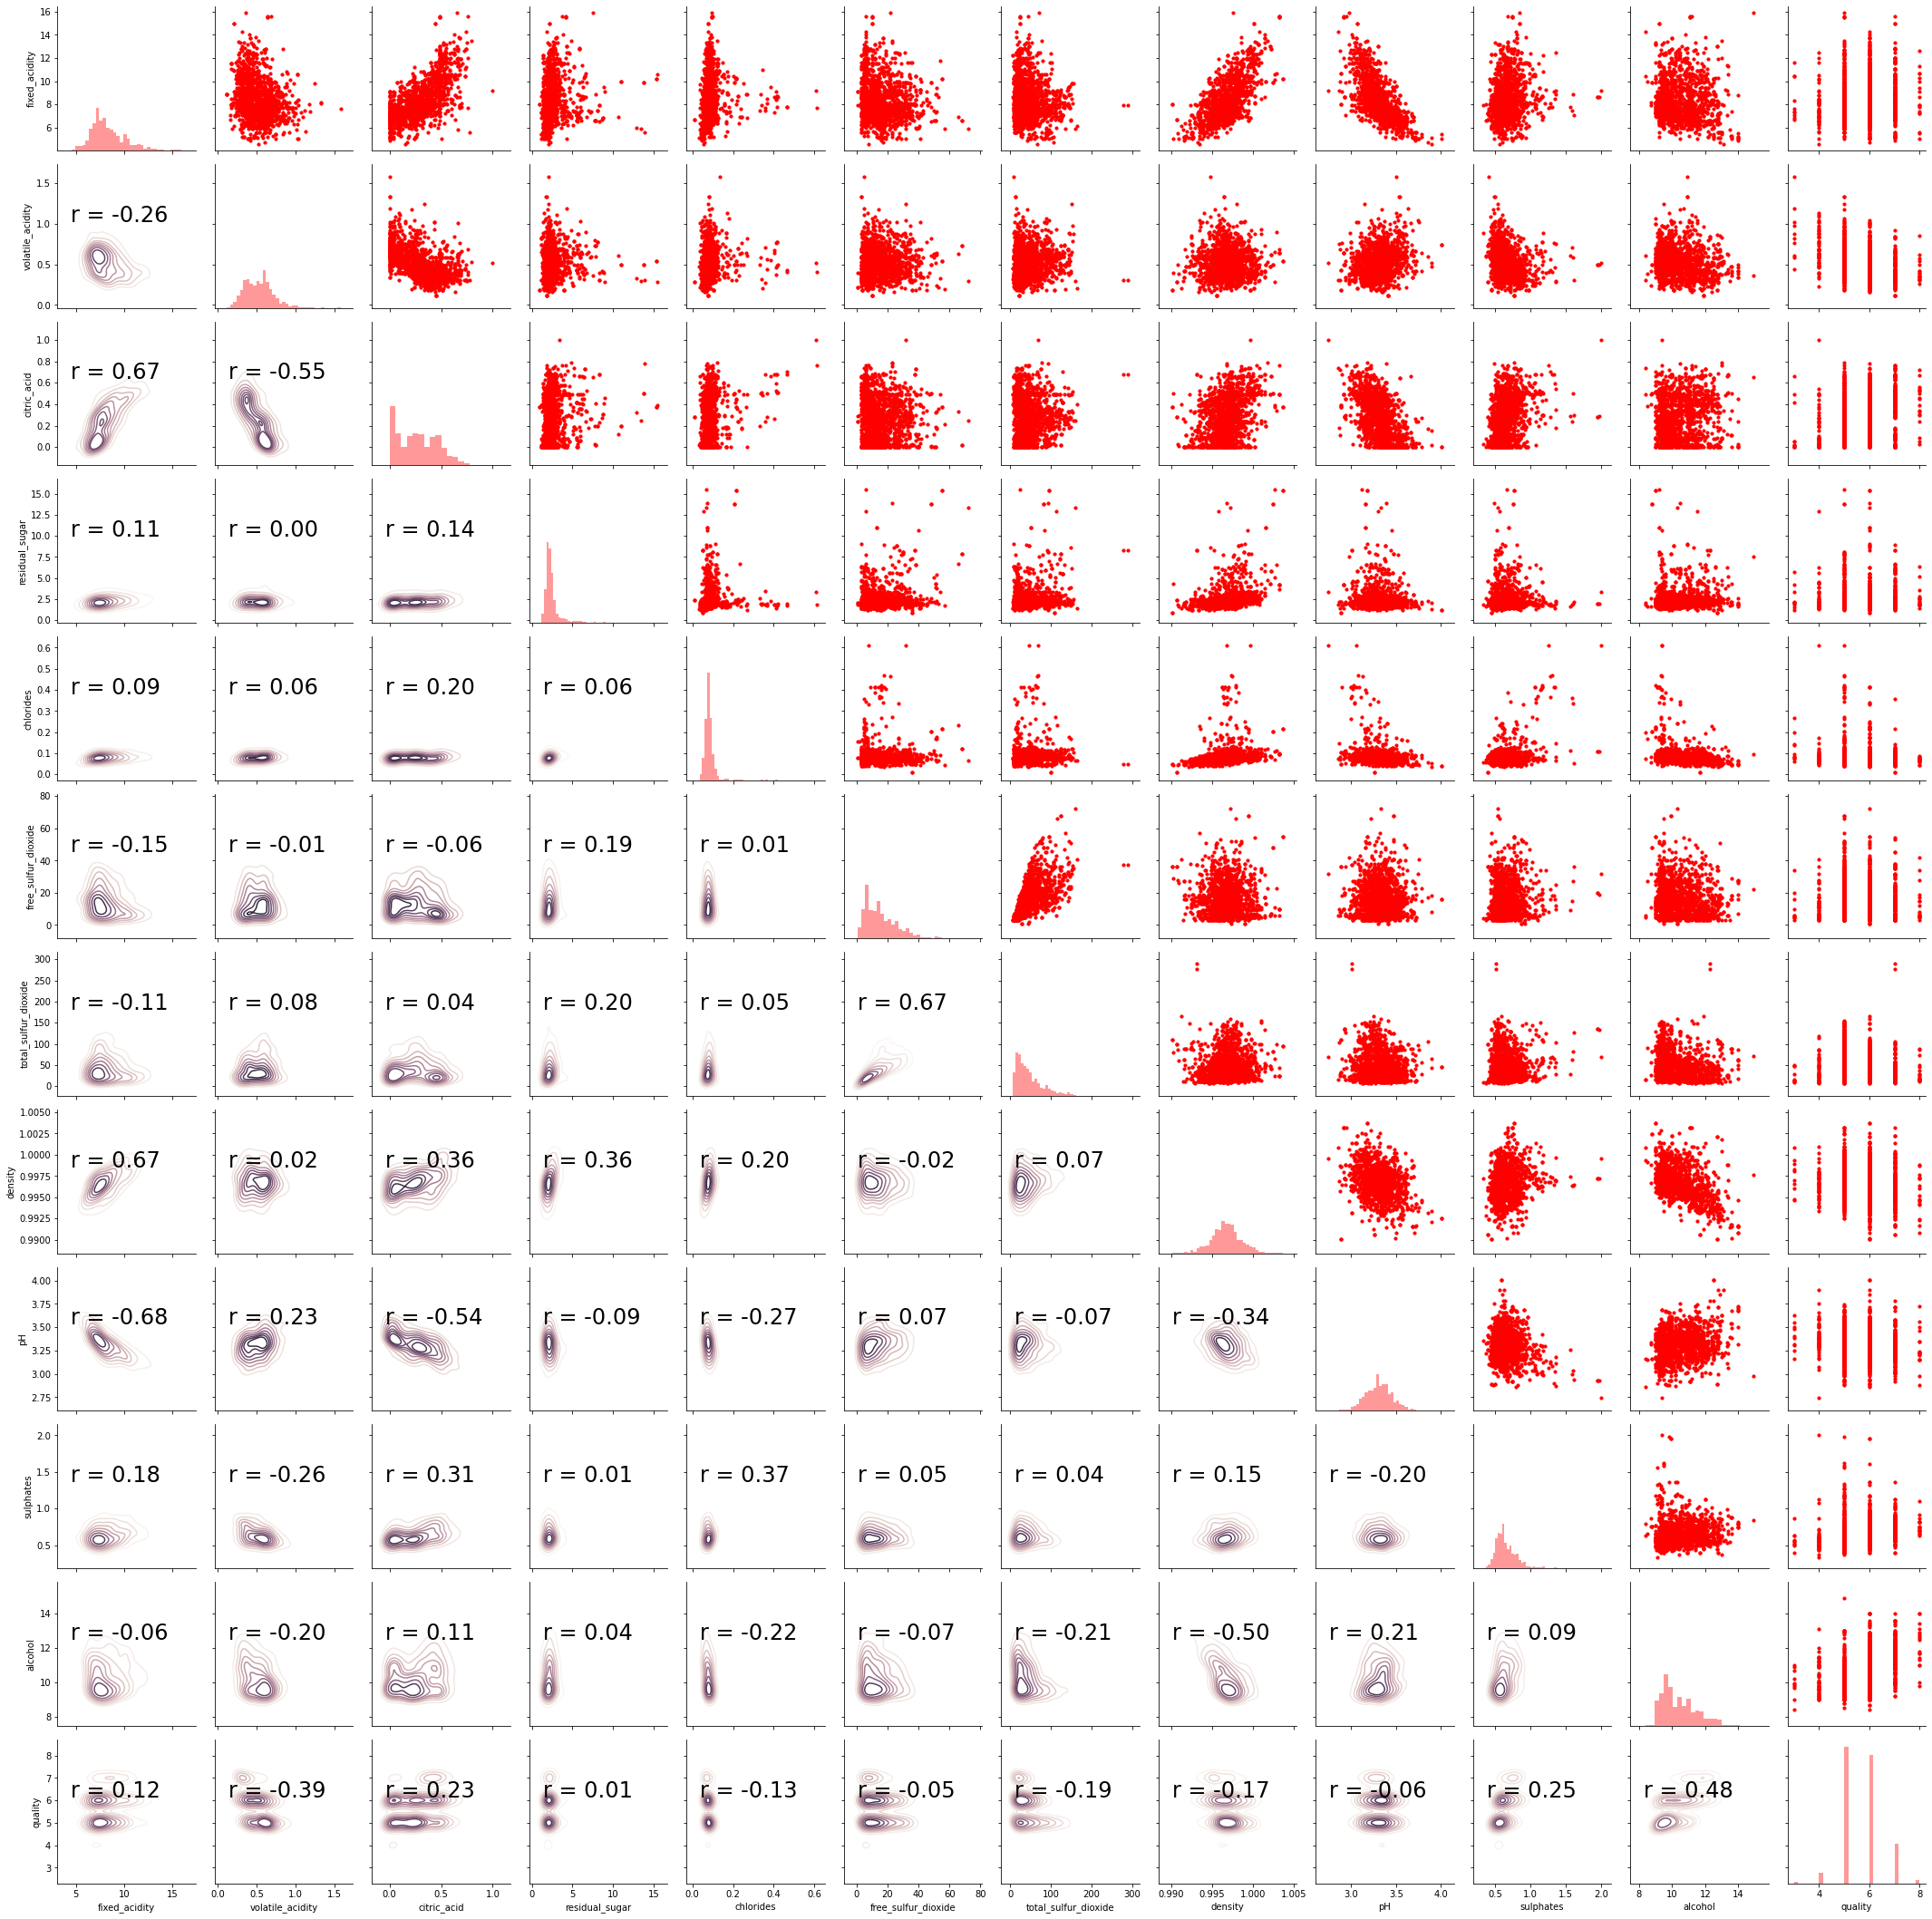

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from scipy import stats

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), 
                xy=(.1, .6), 
                xycoords=ax.transAxes,
                size = 24)
    
# Set the color palette to use    
cmap = sns.cubehelix_palette(light=1, dark = 0.1, hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(random_df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap = cmap)

Keeping the two best correlated features and dropping ['residual_sugar', 'free_sulfur_dioxide', 'pH', 'fixed_acidity', 'chlorides', 'density', 'total_sulfur_dioxide', 'citric_acid', 'sulphates']

In [ ]:
feature_df.drop(columns=['residual_sugar', 'free_sulfur_dioxide', 'pH', 'fixed_acidity', 'chlorides', 'density', 'total_sulfur_dioxide'], inplace=True)

#10.**Model selection via Hyperparameter Tuning**: 
Use the **kFold** function(known as sFold function from previous assignment)to evaluate the performance of your model over each combination of lambd, learning_rateand regularizerfrom the following sets:

  1. lambd= [1.0, 0,0.1,0.01, 0.001, 0.0001]
  2. learning_rate = [0.1, 0.01, 0.001, 0.001]
  3. regularizer= ['l1', 'l2']
  4. Store the returned dictionary for each and ***present it in the report***.
  5. Determine the best model (model selection) based on the overall performance(lowest average error).
    - For the error_function argument of the kFold function use the “mse" function.
    - For the model selection **don’t augment the features**.

In [ ]:
results_list = []
run_number = 1
for lambd in [1.0, 0, 0.1, 0.01, 0.001, 0.0001]:
  for learning_rate in [0.1, 0.01, 0.001, 0.001]:
    for regularizer in ['l1', 'l2']:
      results, train_scores, val_scores, train_sizes = \
      learning_curve(
          Linear_Regression(algorithm=batch_gradient_descent),
          feature_df.to_numpy(), 
          target_df.to_numpy(),
          cv=5, 
          train_size=np.linspace(0.1,1,num=50), 
          learning_rate=learning_rate,
          epochs=1000,
          tol=None,
          regularizer=regularizer,
          lambd=lambd,
          error_function=mean_squared_error)
      
      title = u'Run {}: \u03BB {} \u03B1 {} regularizer "{}"'\
      .format(run_number, lambd, learning_rate, regularizer)

      results_list.append([results, train_scores, 
                           val_scores, 
                           train_sizes.tolist(), 
                           title])

      run_number += 1



In [ ]:
import json

In [ ]:
json.dumps(results_list,indent=1)

'[\n [\n  [\n   {\n    "k0": {\n     "train_score": 31.647818594568676,\n     "validation_score": 34.33929230300614\n    },\n    "k1": {\n     "train_score": 31.058821285746067,\n     "validation_score": 36.83446787676422\n    },\n    "k2": {\n     "train_score": 32.08534039079702,\n     "validation_score": 33.584980759976126\n    },\n    "k3": {\n     "train_score": 32.82083308287002,\n     "validation_score": 31.188138794398167\n    },\n    "k4": {\n     "train_score": 32.13181853550658,\n     "validation_score": 31.887903394335233\n    }\n   },\n   {\n    "k0": {\n     "train_score": 31.69311994118065,\n     "validation_score": 33.05292357520021\n    },\n    "k1": {\n     "train_score": 30.769572036205627,\n     "validation_score": 36.42007863436696\n    },\n    "k2": {\n     "train_score": 32.4210184527961,\n     "validation_score": 31.765848374093004\n    },\n    "k3": {\n     "train_score": 32.0285190176346,\n     "validation_score": 31.4298549336752\n    },\n    "k4": {\n     "t

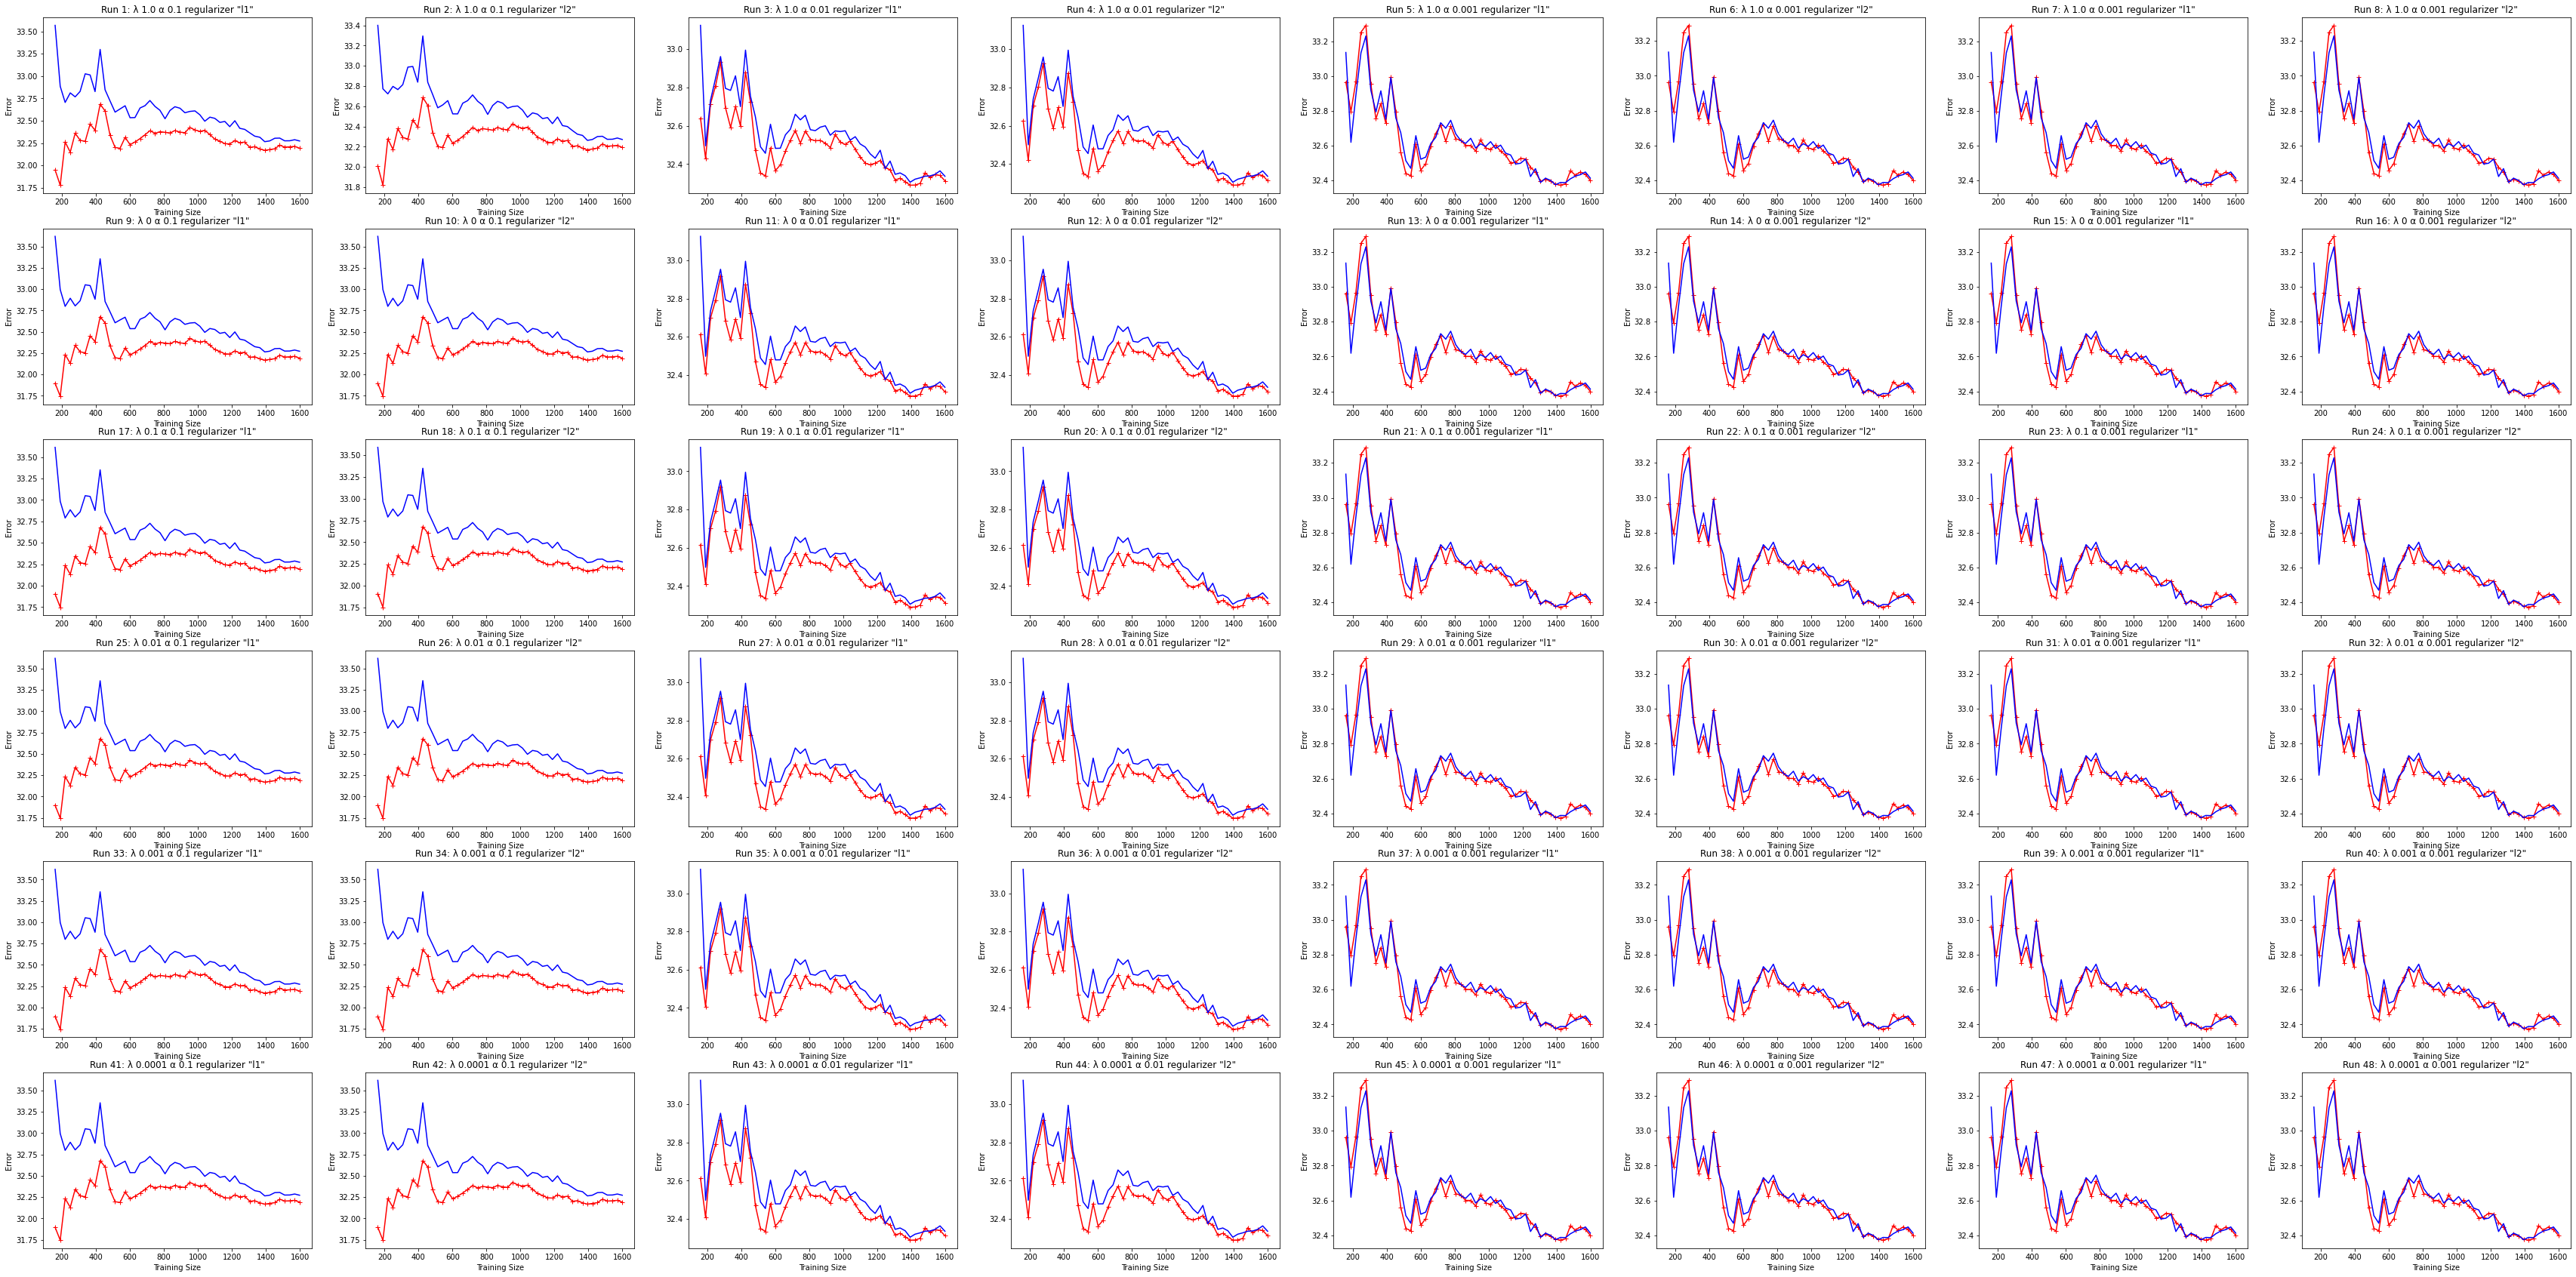

In [ ]:
fig = plt.figure(figsize=(60,30))
gs = gridspec.GridSpec(6, 8, fig)
i = 0
for results in results_list:
  ax = fig.add_subplot(gs[i])
  i += 1
  ax.plot(results[3], results[1], 'r-+', label='Training Score')
  ax.plot(results[3], results[2], 'b-', label='Validation Score')
  ax.set_title(results[4])
  ax.set_xlabel("Training Size")
  ax.set_ylabel("Error")
  


In [ ]:
i = 1
validation_averages = []
training_averages = []

for results in results_list:
  validation_averages.append(np.average(results[1]))
  training_averages.append(np.average(results[1]))

validation_averages = np.asarray(validation_averages)
training_averages = np.asarray(training_averages)

best_model = np.where(
    validation_averages == np.min(validation_averages))[0][0]
print("Best Run {}".format(best_model+1))


Best Run 9


In [ ]:
runs = []
for lambd in [1.0, 0, 0.1, 0.01, 0.001, 0.0001]:
  for learning_rate in [0.1, 0.01, 0.001, 0.001]:
    for regularizer in ['l1', 'l2']:
      runs.append([lambd, learning_rate, regularizer])

In [ ]:
print(runs[best_model])

[0, 0.1, 'l1']


# 12

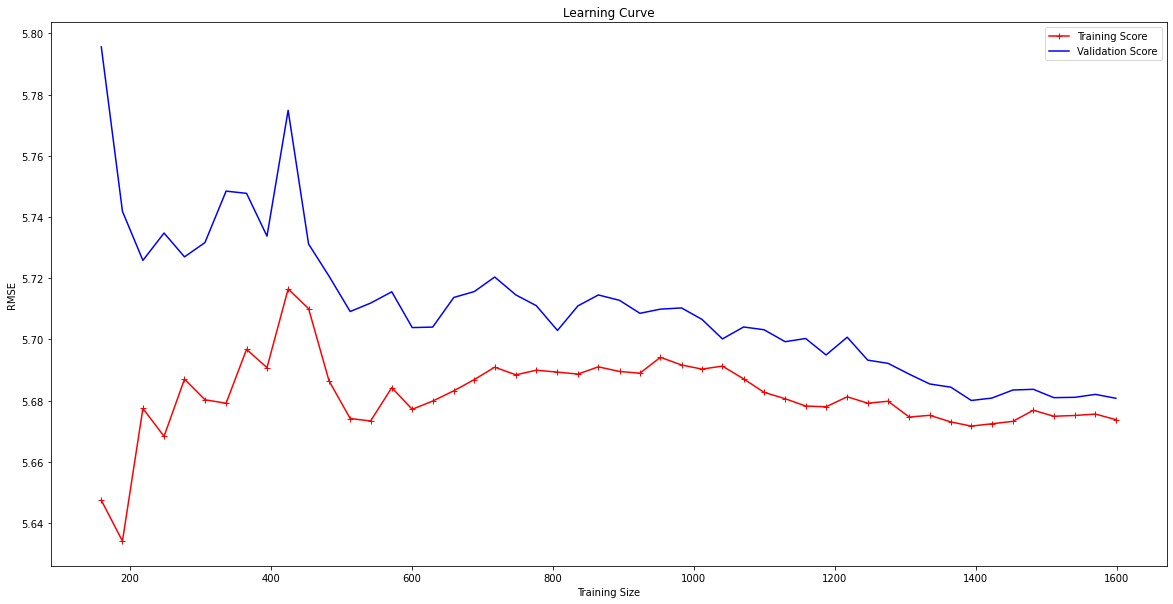

In [ ]:

results, train_scores, val_scores, train_sizes = learning_curve(
    Linear_Regression(algorithm=batch_gradient_descent),
    feature_df.to_numpy(), 
    target_df.to_numpy(),
    cv=5, 
    train_size=np.linspace(0.1,1,num=50), 
    learning_rate=runs[best_model][1],
    epochs=1000,
    tol=None, 
    regularizer=runs[best_model][2], 
    lambd=runs[best_model][0],
    error_function=root_mean_squared_error)

fig = plt.figure(figsize=(20,10))
plt.plot(train_sizes, train_scores, 'r-+', label='Training Score')
plt.plot(train_sizes, val_scores, 'b-', label='Validation Score')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.legend()


# 13

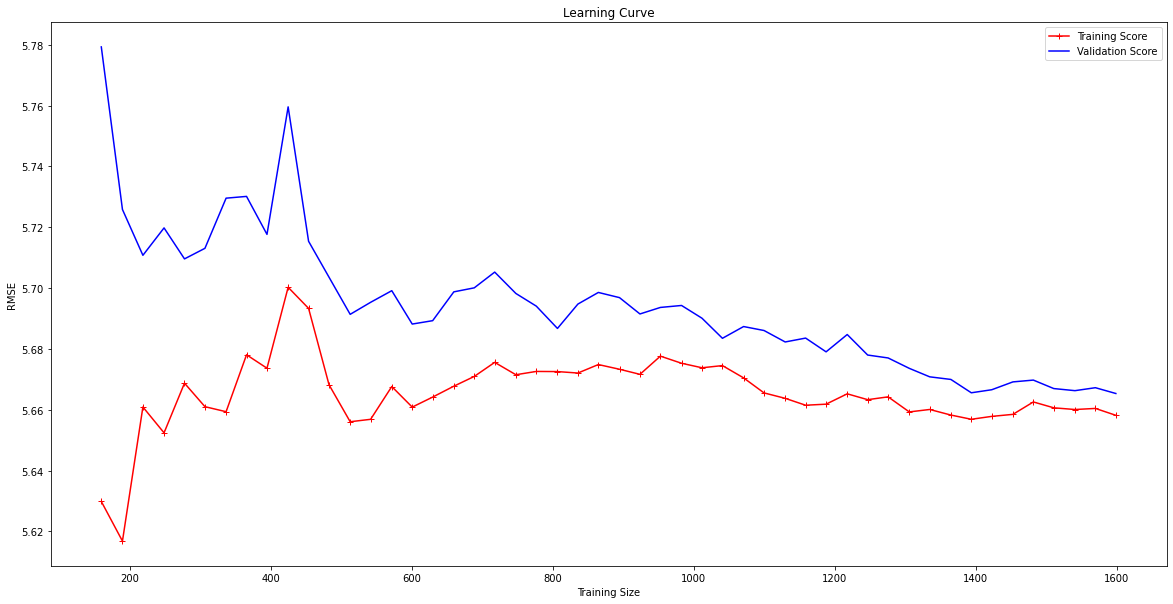

In [ ]:
results, train_scores, val_scores, train_sizes = learning_curve(
    Linear_Regression(algorithm=batch_gradient_descent),
    polynomial_features(feature_df.to_numpy(), 3), 
    target_df.to_numpy(),
    cv=5, 
    train_size=np.linspace(0.1,1,num=50), 
    learning_rate=runs[best_model][1], 
    regularizer=runs[best_model][2],
    epochs=1000,
    tol=None,
    lambd=runs[best_model][0],
    error_function=root_mean_squared_error)

fig = plt.figure(figsize=(20,10))
plt.plot(train_sizes, train_scores, 'r-+', label='Training Score')
plt.plot(train_sizes, val_scores, 'b-', label='Validation Score')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.legend()


# 14

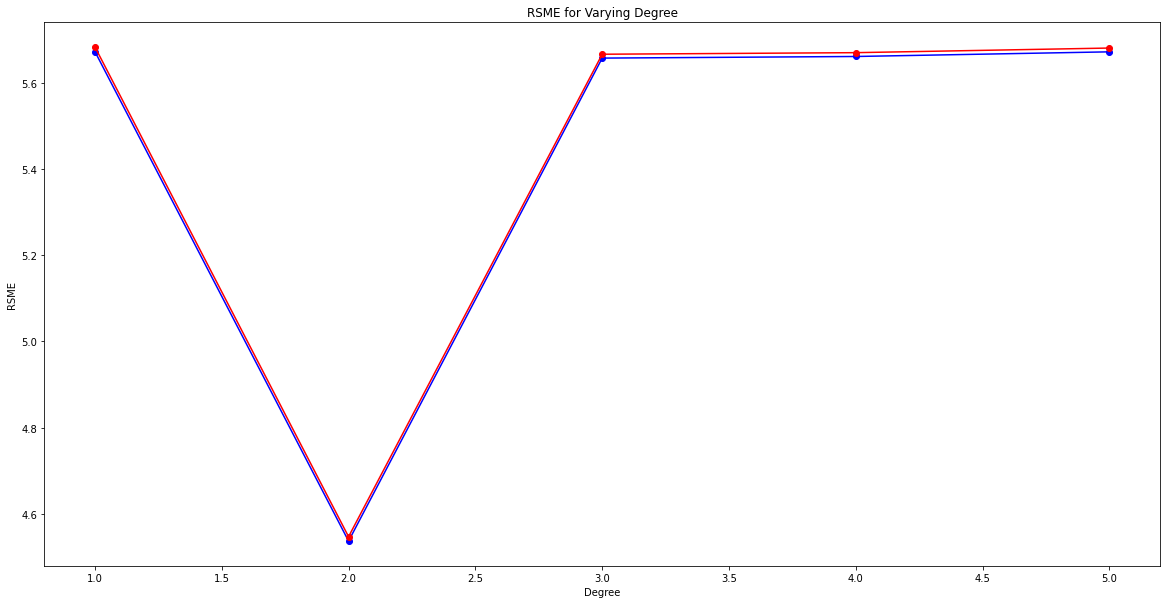

In [ ]:
plot_polynomial_model_complexity(Linear_Regression(batch_gradient_descent),
                                 feature_df.to_numpy(),
                                 target_df.to_numpy(),
                                 5,
                                 5,
                                 root_mean_squared_error,
                                 learning_rate=0.1,
                                 regularizer='l1',
                                 lambd=0)

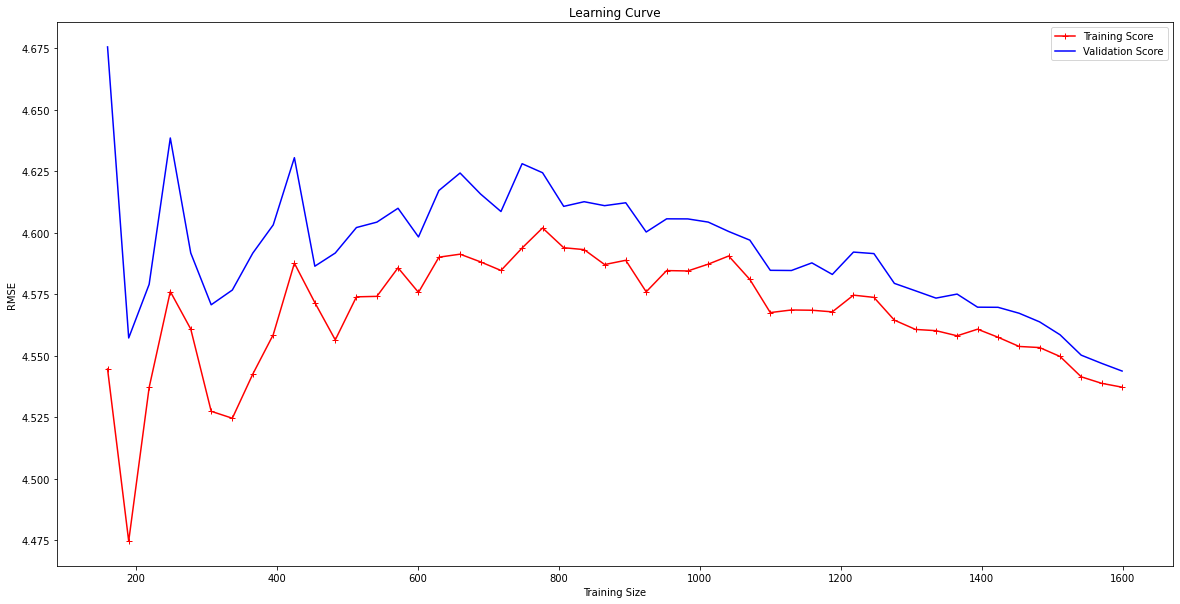

In [ ]:
results, train_scores, val_scores, train_sizes = learning_curve(
    Linear_Regression(algorithm=batch_gradient_descent),
    polynomial_features(feature_df.to_numpy(), 2), 
    target_df.to_numpy(),
    cv=5, 
    train_size=np.linspace(0.1,1,num=50), 
    learning_rate=runs[best_model][1], 
    regularizer=runs[best_model][2],
    epochs=1000,
    tol=None,
    lambd=runs[best_model][0],
    error_function=root_mean_squared_error)

fig = plt.figure(figsize=(20,10))
plt.plot(train_sizes, train_scores, 'r-+', label='Training Score')
plt.plot(train_sizes, val_scores, 'b-', label='Validation Score')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.legend()


#15

In [ ]:
def stochastic_gradient_descent(learning_rate, 
                                X, 
                                Y, 
                                epochs, 
                                tol, 
                                regularizer, 
                                lambd):
  
  n = X.shape[0]
  alpha = learning_rate
  theta = np.zeros(shape=(X.shape[1], 1))
  X_sample = np.asarray([X[0]])
  Y_sample = np.asarray([Y[0]])

  for i in range(1, n):
    X_sample = X[0:i]
    Y_sample = Y[0:i]
    
    # hyp = X_sample.dot(theta)
    # loss = np.subtract(hyp, Y_sample)
    # gradient = X_sample.T.dot(loss) / n
    gradient = X_sample.T.dot(np.subtract(X_sample.dot(theta), Y_sample)) / (i+1)
    
    theta = theta - alpha  * gradient
              
  
  return theta

In [ ]:
results_list = []
i = 1
for learning_rate in [0.1, 0.01, 0.001, 0.001]:
      results, train_scores, val_scores, train_sizes = \
      learning_curve(
          Linear_Regression(algorithm=stochastic_gradient_descent),
          feature_df.to_numpy(), 
          target_df.to_numpy(), 
          cv=5,
          train_size=np.linspace(0.1,1,num=50),
          learning_rate=learning_rate,
          epochs=50,
          tol=None,
          regularizer=None,
          lambd=0,
          error_function=mean_squared_error)
      title = u'Run {}: \u03BB {} \u03B1 {} regularizer "{}"'\
      .format(i, lambd, learning_rate, regularizer)
      i += 1
      results_list.append([results, train_scores, val_scores, train_sizes.tolist(), title])

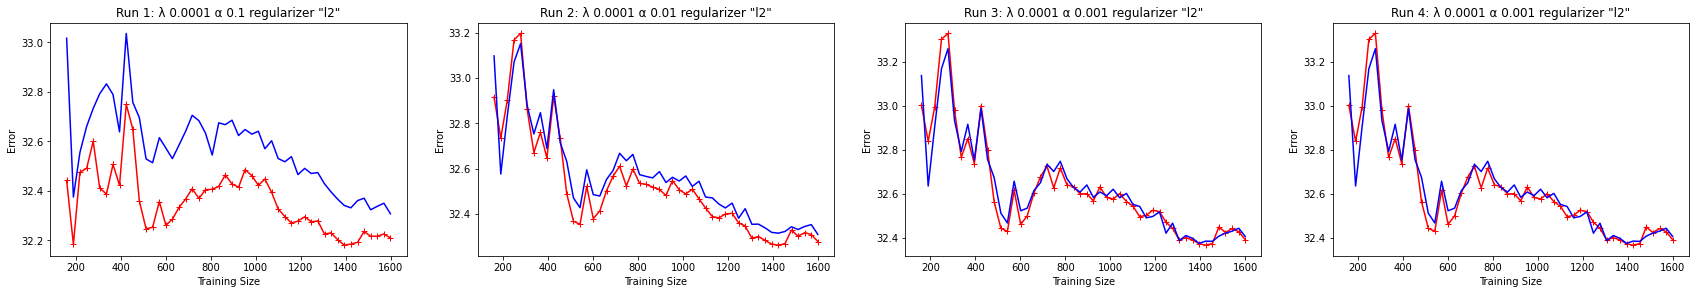

In [ ]:
fig = plt.figure(figsize=(60,30))
gs = gridspec.GridSpec(6, 8, fig)
i = 0
for results in results_list:
  ax = fig.add_subplot(gs[i])
  i += 1
  ax.plot(results[3], results[1], 'r-+', label='Training Score')
  ax.plot(results[3], results[2], 'b-', label='Validation Score')
  ax.set_title(results[4])
  ax.set_xlabel("Training Size")
  ax.set_ylabel("Error")
  


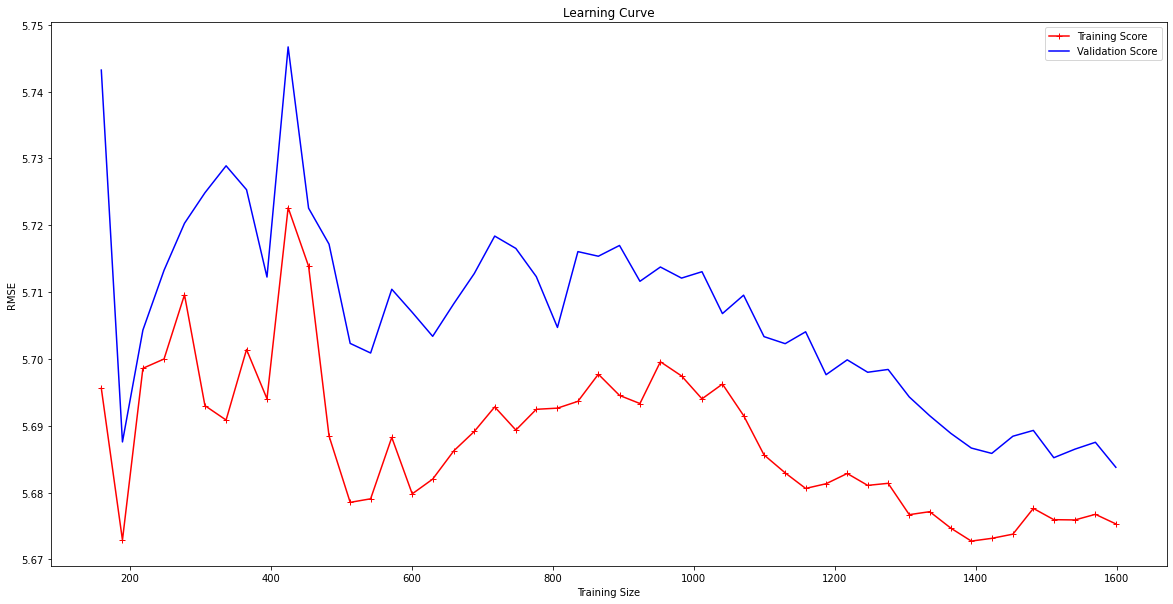

In [ ]:
results, train_scores, val_scores, train_sizes = \
learning_curve(
  Linear_Regression(algorithm=stochastic_gradient_descent),
  feature_df.to_numpy(), 
  target_df.to_numpy(),
  cv=5, 
  train_size=np.linspace(0.1,1,num=50), 
  learning_rate=0.1,
  epochs=50,
  lambd=0,
  error_function=root_mean_squared_error)
fig = plt.figure(figsize=(20,10))
plt.plot(train_sizes, train_scores, 'r-+', label='Training Score')
plt.plot(train_sizes, val_scores, 'b-', label='Validation Score')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.legend()